In [1]:
# Import necessary libraries
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import dowhy
from dowhy import CausalModel



warnings.filterwarnings('ignore')

def load_data(filepath):
    df = pd.read_csv(filepath, sep=';', header=None, skiprows=0)
    df.columns = df.iloc[0]
    df = df[1:]
    return df

def filter_data(df):
    df = df[(df['Property Type'] == 'House') & (df['Room Type'] == 'Entire home/apt')]
    return df

def drop_unnecessary_columns(df):
    columns_to_drop = ["Listing Url","Last Scraped","Name","Summary","Space","Description",
                    "Experiences Offered","Neighborhood Overview","Notes","Transit",
                    "Scrape ID","Access","Interaction","House Rules","Thumbnail Url",
                    "Medium Url","Picture Url","License","Jurisdiction Names",
                    "Monthly Price", "Features", "Host Listings Count", "Host Total Listings Count",
                    "Cancellation Policy","Calculated host listings count","XL Picture Url","Host URL",
                   "Host Name","Host About","Host Response Time","Host Since","Host Location"
                    ,"Host Response Rate","Host Thumbnail Url","Host Picture Url", "Weekly Price",
                    "Host Acceptance Rate","Host Neighbourhood","Host Verifications","Street",
                    "Square Feet", "Security Deposit",'Availability 30', 'Availability 60', 'Availability 90', 'Availability 365',
                    "Neighbourhood","Neighbourhood Cleansed", "Neighbourhood Group Cleansed","City",
                    "State","Market","Smart Location", "Country Code","Country", "First Review",
                    "Last Review", "Calendar Updated", "Has Availability", "Calendar last Scraped",
                    "Zipcode","Property Type","Room Type","Bed Type", "Latitude","Longitude","ID","Host ID","Geolocation"]
    df = df.drop(columns_to_drop, axis=1)
    return df

def extract_unique_amenities(df):
    df['Amenities'] = df['Amenities'].astype(str)
    all_amenities_str = ','.join(df['Amenities'])
    all_amenities_set = set(all_amenities_str.split(','))
    return all_amenities_set

def count_amenities(df):
    amenities_count = {}
    for amenities_str in df['Amenities']:
        amenities_list = amenities_str.split(',')
        for amenity in amenities_list:
            if amenity not in amenities_count:
                amenities_count[amenity] = 1
            else:
                amenities_count[amenity] += 1
    amenities_count_sorted = dict(sorted(amenities_count.items(), key=lambda item: item[1], reverse=True))
    return amenities_count_sorted

def create_amenities_dummies(df):
    df['Amenities'] = df['Amenities'].apply(lambda x: x.split(','))
    amenities_dummies = pd.get_dummies(df['Amenities'].apply(pd.Series).stack()).sum(level=0)
    df = pd.concat([df, amenities_dummies], axis=1)
    df = df.drop("Amenities", axis=1)
    return df

def combine_columns(df):
    df.columns = [col.lower().strip() for col in df.columns]
    df = df.T.groupby(df.columns).agg('sum').T
    return df

def preprocess_data(df):
    df = filter_data(df)
    df = drop_unnecessary_columns(df)
    unique_amenities = extract_unique_amenities(df)
    amenities_count_sorted = count_amenities(df)
    df = create_amenities_dummies(df)
    df = combine_columns(df)
    

    df = df.drop([
        'review scores accuracy', 'review scores checkin', 'review scores cleanliness',
        'review scores communication', 'review scores location', 'review scores rating',
        'review scores value', 'reviews per month', 'smart lock', 'smartlock',
    ], axis=1)
    return df

# Load and preprocess data
file_path = r"C:\Users\nstep\TSU\SeniorProject\USAAirbnb.csv"
raw_data = load_data(file_path)
preprocessed_data = preprocess_data(raw_data)

# Print results
print(preprocessed_data)


       24-hour check-in accessible-height bed accessible-height toilet  \
8                     0                     0                        0   
11                    0                     0                        0   
19                    0                     0                        0   
27                    1                     0                        0   
70                    0                     0                        0   
...                 ...                   ...                      ...   
134535              1.0                   0.0                      0.0   
134536              1.0                   0.0                      0.0   
134537              0.0                   0.0                      0.0   
134544              0.0                   0.0                      0.0   
134545              0.0                   0.0                      0.0   

       accommodates air conditioning baby bath baby monitor  \
8                 8                1         0  

In [2]:
#copy preprocessed_data to subsetdf
subsetdf = preprocessed_data.copy()

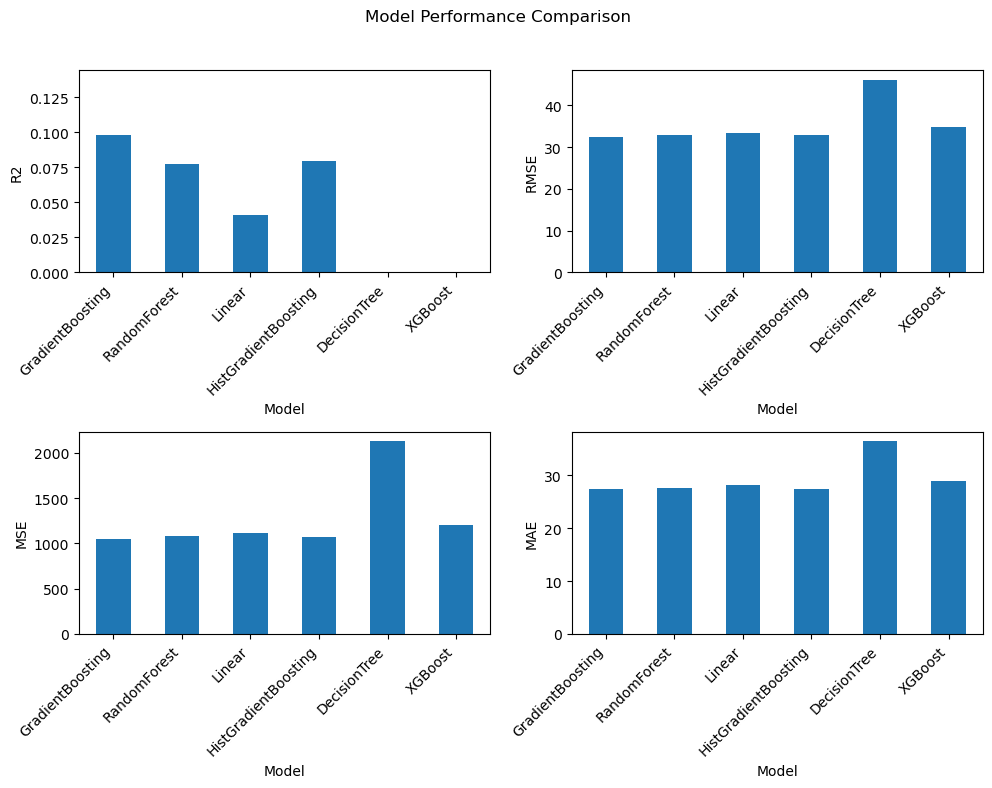

                            MAE          MSE        R2       RMSE
Model                                                            
DecisionTree          36.493927  2129.773279 -0.822735  46.149467
GradientBoosting      27.412276  1053.657710  0.098243  32.460094
HistGradientBoosting  27.529761  1075.548961  0.079507  32.795563
Linear                28.145616  1120.390530  0.041130  33.472235
RandomForest          27.616053  1077.904772  0.077491  32.831460
XGBoost               28.996367  1206.594406 -0.032646  34.736068


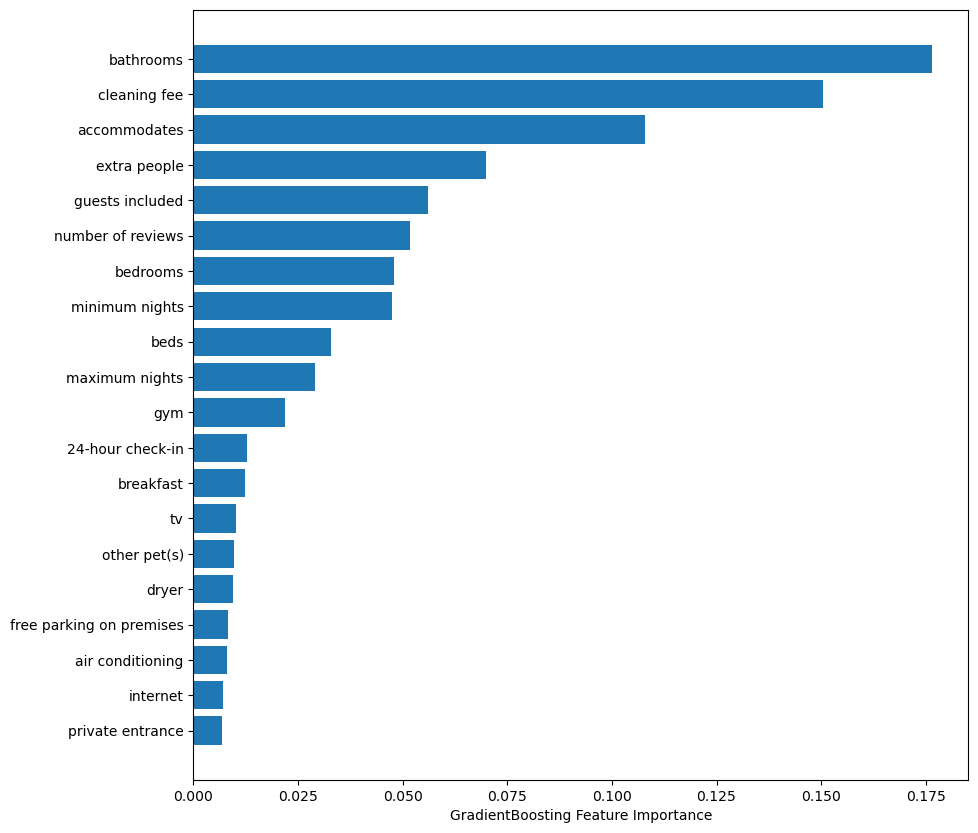

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import xgboost as xgb

subsetdf = preprocessed_data.copy()
target_col ='price'
subsetdf[target_col] = pd.to_numeric(subsetdf[target_col], errors='coerce')
subsetdf = subsetdf[(subsetdf['price'] <= 300) & (subsetdf['price'] >= 200)]
df = subsetdf.copy()

def prepare_data(df, target_col='price'):
    # Convert the 'price' column to numeric, setting errors='coerce' to convert invalid parsing to NaN
    df[target_col] = pd.to_numeric(df[target_col], errors='coerce')
    
    # Drop any rows with NaN values in the 'price' column
    df = df.dropna(subset=[target_col])
    
    # Filter out rows where price is over 300 and greater then 200
    df = df[(df[target_col] <= 300) & (df[target_col] >= 200)]

    
    X = df.drop(target_col, axis=1)
    y = df[target_col]
    return train_test_split(X, y, test_size=0.2, random_state=42)


def create_models():
    return {
        'GradientBoosting': GradientBoostingRegressor(),
        'RandomForest': RandomForestRegressor(),
        'Linear': LinearRegression(),
        'HistGradientBoosting': HistGradientBoostingRegressor(),
        'DecisionTree': DecisionTreeRegressor(),
        'XGBoost': xgb.XGBRegressor(),
    }

def fit_models(X_train, y_train, models):
    for name, model in models.items():
        model.fit(X_train.astype(float), y_train.astype(float))
    return models

def evaluate_models(X_test, y_test, models):
    results = []
    for name, model in models.items():
        y_pred = model.predict(X_test.astype(float))

        r2 = r2_score(y_test.astype(float), y_pred)
        mse = mean_squared_error(y_test.astype(float), y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test.astype(float), y_pred)

        results.append({
            'Model': name,
            'R2': r2,
            'RMSE': rmse,
            'MSE': mse,
            'MAE': mae
        })
    return pd.DataFrame(results)

def plot_model_performance(results_df):
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    fig.suptitle('Model Performance Comparison')

    metrics = ['R2', 'RMSE', 'MSE', 'MAE']

    for idx, metric in enumerate(metrics):
        ax = axes[idx // 2, idx % 2]
        results_df.plot(x='Model', y=metric, kind='bar', ax=ax, legend=None)
        ax.set_ylabel(metric)
        ax.set_ylim(bottom=0)
        ax.set_xticklabels(results_df['Model'], rotation=45, ha='right')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


def plot_feature_importances(model, X_train, n=20):
    """
    Plot the top n important features.
    """
    feature_importances = model.feature_importances_
    sorted_idx = np.argsort(feature_importances)[-n:]
    
    plt.figure(figsize=(10, 10))
    plt.barh(range(n), feature_importances[sorted_idx])
    plt.yticks(range(n), X_train.columns[sorted_idx])
    plt.xlabel("GradientBoosting Feature Importance")
    plt.show()




def main(df):
    X_train, X_test, y_train, y_test = prepare_data(df)
    models = create_models()
    models = fit_models(X_train, y_train, models)
    results_df = evaluate_models(X_test, y_test, models)
    plot_model_performance(results_df)
    table = pd.pivot_table(results_df, index='Model', values=['R2', 'RMSE', 'MSE', 'MAE'])
    print(table)

    # After your models are trained:
    models = fit_models(X_train, y_train, models)
    plot_feature_importances(models['GradientBoosting'], X_train, n=20)

main(df)